In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re
from PIL import Image

from wordcloud import WordCloud
import spacy
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Downloads

In [2]:
#show all files in the input directory
arr = os.listdir('../input/')
arr_df = pd.DataFrame(arr, columns = ['file_name'])
arr_df

,file_name
0,file_1957857_3090367_7986.jl
1,.DS_Store
2,file_2048814_3090367_7987.jl
3,file_1669220_3090367_7993.jl
4,file_1669220_3090367_7992.jl
5,file_1933818_3090367_4518.jl
6,file_2070949_3090367_3788.jl
7,file_1962566_3090367_4329.jl
8,file_1962712_3090367_3798.jl
9,file_11368336_455951711_249.jl


In [3]:
#Choose from the arr_df one file to analyze it (the result of parsing)

file_index = 8
#path = f'../input/file_7321705_455951711_124.jl'
path = f"../input/{arr_df['file_name'][file_index]}"
path

'../input/file_1962712_3090367_3798.jl'

In [4]:
#Make df from parsed choosen file
columns = ['comment', 'date_time', 'color','size', 'thumb_up', 'thumb_down', 'prod_eval', 'prod', 'brand']

df = pd.read_json(path).transpose().reset_index().drop('index', axis=1)
df = df.set_axis(columns, axis = 'columns')
print(df.shape)
df[0:5]

(174, 9)


,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand
0,"Кольцо очень нежное, красивое, блестит , перел...",2021-05-09T11:51:08Z,серебристый,"16,5",1,0,5,кольцо,SOKOLOV
1,"Хорошее колечко, получила 20 марта, ни один ка...",2021-04-20T09:13:31Z,серебристый,18,0,1,4,Кольцо,SOKOLOV
2,"Пока все норм , камни на месте, милое колечко",2021-04-16T14:04:18Z,серебристый,17,1,0,5,Кольцо,SOKOLOV
3,Спустя месяц выпал камень при аккуратном ношен...,2021-03-09T20:34:29Z,серебристый,17,1,0,1,Кольцо,SOKOLOV
4,"Очень красивое кольцо. Кого интересует проба,...",2021-03-07T08:26:12Z,серебристый,18,2,1,5,Кольцо,SOKOLOV


# Functions for text cleaning (symbols and stop-words)

In [5]:
#function which delete all non-letters symbols
def delete_non_letters(words):
    new_words = []
    words = words.split()
    
    for word in words:
        new_word = "".join(c if c.isalpha() else " " for c in word )
        
        if new_word != '':
            new_words.append(new_word)
    text = ' '.join(c for c in new_words)
        
    return text

In [6]:
#leave only russian letters
def clean_text(text):
    text = text.lower()
    text = text.split()
    text = ' '.join(re.sub("[^А-Яа-яё]",'', i) for i in text)
    text = delete_non_letters(text)
    
    return text


In [7]:
#delete stop-words which are in the list"russian_stopwords"
def delete_stopwords(text): 
    text = text.split()
    text = [w for w in text if not w in russian_stopwords and len(w) >= 3]
    text = " ".join(text)
    
    return text

In [8]:
#text lemmatization with MySTem. In order to make it work faster we need to join all comments with the "|" delimeter
#and than split by that symbol

def lemmatize(text): 
    text =  [i for i in text]
    m = Mystem()
    merged_text = "|".join(text)

    doc = []
    res = []
    count = 0
    lemma = m.lemmatize(merged_text)
    for t in lemma:
        
        if '|' not in t and count+1<len(lemma):
            doc.append(t)
            count+=1
          
        else:
            doc = ''.join(i for i in doc)
            res.append(doc)
            count+=1
            doc = []
    return res

In [9]:
df.head()

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand
0,"Кольцо очень нежное, красивое, блестит , перел...",2021-05-09T11:51:08Z,серебристый,"16,5",1,0,5,кольцо,SOKOLOV
1,"Хорошее колечко, получила 20 марта, ни один ка...",2021-04-20T09:13:31Z,серебристый,18,0,1,4,Кольцо,SOKOLOV
2,"Пока все норм , камни на месте, милое колечко",2021-04-16T14:04:18Z,серебристый,17,1,0,5,Кольцо,SOKOLOV
3,Спустя месяц выпал камень при аккуратном ношен...,2021-03-09T20:34:29Z,серебристый,17,1,0,1,Кольцо,SOKOLOV
4,"Очень красивое кольцо. Кого интересует проба,...",2021-03-07T08:26:12Z,серебристый,18,2,1,5,Кольцо,SOKOLOV


# Stopwords extension

In [10]:

file_name = 'StopWords_extension.csv'
path = f'../{file_name}'
SW = pd.read_csv(path, index_col = 'Index')
SW_list = SW['Word'].tolist()

In [11]:
#clean new StopWords 
prod_text = clean_text(df['prod'][0])
brand_text = clean_text(df['brand'][0])

In [12]:
#make custom list of StopWords (from df columns"prod" and "brand") 
stopwords_add_by_hand = [] #list for add later in file 'StopWords_extension.csv'
stopwords_add_by_category = [i for i in brand_text.split()]+[i for i in prod_text.split()]
stopwords_add_by_category += lemmatize(stopwords_add_by_category)
stopwords_add_by_category

['кольцо', 'кольцо']

In [13]:
#full list of russian StopWords for this good
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(stopwords_add_by_hand+stopwords_add_by_category+SW_list)

# Clean comments before lemmatization

In [14]:
df['cleaned_comment'] = df['comment'].map(lambda x: clean_text(x))
df['cleaned_comment'] = df['cleaned_comment'].map(lambda x: delete_stopwords(x))

In [15]:
df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment
0,"Кольцо очень нежное, красивое, блестит , перел...",2021-05-09T11:51:08Z,серебристый,"16,5",1,0,5,кольцо,SOKOLOV,нежное красивое блестит переливается
1,"Хорошее колечко, получила 20 марта, ни один ка...",2021-04-20T09:13:31Z,серебристый,18,0,1,4,Кольцо,SOKOLOV,хорошее колечко получила марта камушек выпал н...
2,"Пока все норм , камни на месте, милое колечко",2021-04-16T14:04:18Z,серебристый,17,1,0,5,Кольцо,SOKOLOV,норм камни месте милое колечко
3,Спустя месяц выпал камень при аккуратном ношен...,2021-03-09T20:34:29Z,серебристый,17,1,0,1,Кольцо,SOKOLOV,спустя месяц выпал камень аккуратном ношении и...
4,"Очень красивое кольцо. Кого интересует проба,...",2021-03-07T08:26:12Z,серебристый,18,2,1,5,Кольцо,SOKOLOV,красивое интересует проба буква


# Mystem lemmatization and drop empty comments

In [16]:
#delete empty comments after cleaning
df = df.drop(df[df['cleaned_comment']==''].index).reset_index(drop = True)

In [17]:
#lemmatization with Mystem
df['lemma_comment'] = lemmatize(df['cleaned_comment'])

# Delete StopWords

In [18]:
df['lemma_comment'] = df['lemma_comment'].map(lambda x: delete_stopwords(x))
df = df.drop(df[df['lemma_comment']==''].index).reset_index(drop = True)

In [19]:
df.tail(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment
163,Очень милое и аккуратное колечко)смотрится на ...,2015-08-06T10:37:59+03:00,серебристый,,3,0,5,Кольцо,SOKOLOV,милое аккуратное колечкосмотрится дороже ценыи...,милый аккуратный колечкосмотреться дорогой цен...
164,Хорошенькое.Спасибо,2015-06-23T19:43:12+03:00,серебристый,,1,1,5,Кольцо,SOKOLOV,хорошенькоеспасибо,хорошенькоеспасибо
165,"очень нежное колечко, понравилось, на солнышке...",2015-06-21T23:00:01+03:00,серебристый,,6,0,5,Кольцо,SOKOLOV,нежное колечко понравилось солнышке искусствен...,нежный колечко солнышко искусственный освещени...
166,"Маломерит на 0,5 размера.",2015-06-16T00:07:01+03:00,серебристый,,3,2,5,Кольцо,SOKOLOV,маломерит размера,маломерить размер
167,Кольцо очень красивое!!! Блестит как настоящий...,2015-05-22T09:28:10+03:00,серебристый,,9,0,5,Кольцо,SOKOLOV,красивое блестит настоящий брилллиантна руке с...,красивый блестеть настоящий брилллиантный смот...


In [20]:
preprocessed_comments = df['lemma_comment']

# IDF1

In [21]:
#vectorization without words, that meet 2 times or less
vectorizer = TfidfVectorizer(min_df=2)
vectorizer.fit_transform(preprocessed_comments)

<168x136 sparse matrix of type '<class 'numpy.float64'>'
	with 699 stored elements in Compressed Sparse Row format>

In [22]:
#creating a dictionary mapping the tokens to their idf values
idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
idf = pd.DataFrame(columns=['idf']).from_dict(
                    dict(idf), orient='index')
idf.columns = ['idf']

In [23]:
idf

,idf
аккуратно,4.520461
аккуратный,3.932674
бижутерия,5.031286
блестеть,3.932674
большеватый,4.743604
...,...
шикарно,4.520461
шикарный,4.183989
ювелирный,5.031286
явно,5.031286


# IDF1 result

In [24]:
# function that give a part of speech (MyStem)
def pos_define(x):
    m = Mystem()
    w = m.analyze(x)[0]
    pos = w['analysis'][0]['gr'].split(',')[0]
    pos = pos.split('=')[0].strip()
    return pos

In [25]:

idf = idf.sort_values(by=['idf'], ascending=True)

def final_topics(df):
    final_topics = []
    for x in df.index:
        if len(final_topics)<5:
            if pos_define(x) not in ['V','ADV'] and (x not in final_topics):
                final_topics.append(x)
        else: break
    return final_topics

idf1_res = pd.DataFrame(final_topics(idf), columns = ['idf'])
idf1_res

,idf
0,красивый
1,колечко
2,размер
3,камень
4,фианит


# Spacy. Looking for most similar comments for each word

In [26]:
#loading a big russian library
nlp = spacy.load('ru_core_news_lg')

In [27]:
#function that gives 10 the most relevant comments to our query

def top_10_similar(word_for_checking, dataframe, column):

    critical_similarity_value = 0.47 #limitation of similarity rate
    
    word_for_checking = nlp(word_for_checking)
    similarities = []
    pos = []
    for i in range(len(dataframe[column])):
        similarities.append(nlp(dataframe[column][i]).similarity(word_for_checking))
    
    df_temp = dataframe.copy()
    df_temp[f'similarity_to_{word_for_checking}'] = similarities
    
    #similarities, фильтрация в соответствии с critical_similarity_value
    df_temp = df_temp.sort_values(by = f'similarity_to_{word_for_checking}', ascending = False).head(10)
    res = df_temp[df_temp[f'similarity_to_{word_for_checking}'] > critical_similarity_value][['comment', f'similarity_to_{word_for_checking}']]
    res = list(res['comment'])
    
    if len(res)>0:
        return res
    else: 
        return "По вашему запросу совпадений не найдено"

In [28]:
#here we need it only in order to compare intermediate results with future results
top_10_similar('подарок', df,'lemma_comment')

<ipython-input-27-fb0046b9a4e7>:11: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarities.append(nlp(dataframe[column][i]).similarity(word_for_checking))


['Очень красивое и нежное, ношу в комплекте с другим колечком ! Все нравится !!!',
 'мне очень понравилось! купила дочке 17 лет на новый год, блестящее и нарядное, 16 рр соответствует. упаковка тоже норм, можно так дарить. 600 р',
 'Очень красивое колечко',
 'Очень красивое колечко! Взяла 16, немного большемерит.',
 'Красивое, милое колечко. Камни переливаються, очень нежно смотриться.',
 'Очень красивое,  аккуратно  колечко:)',
 'Хорошее колечко, получила 20 марта, ни один камушек не выпал. Но носить его надо одно, либо с похожими кольцами. Когда я одеваю обручальное с бриллиантами и это, то сразу видно что стекляшка 😀',
 'Кольцо очень красивое и очень яркое. Качество замечательное, но для меня слишком большой камень. Отказ в пользу более скромного варианта.',
 'Красивое колечко, в размер. Покупала 28.05.20 и вот сегодня 22 июня выпал камень. Честно никогда с таким не сталкивалась и не первый раз покупаю кольца данного бренда. Смотрю по отзывам не мне одной так "повезло".',
 'Хех,  кр

# Stopwods_extension. IDF once again

(array([ 2.,  2.,  1.,  0.,  2.,  9.,  9., 10., 12., 89.]),
 array([2.08684745, 2.38129135, 2.67573524, 2.97017914, 3.26462304,
        3.55906694, 3.85351083, 4.14795473, 4.44239863, 4.73684253,
        5.03128643]),
 <BarContainer object of 10 artists>)

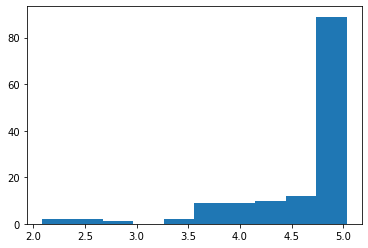

In [29]:
plt.hist(idf.sort_values('idf')['idf'])

In [30]:
#limits for idf value, which we will delete (the lower idf value, the more often it occures in the text)
#values were choosen empirically
max_lim = 6
min_lim = 3

In [31]:
#we add to the stoplist all words with idf value more than 6 and less than 3
SW_idf = idf[(idf['idf']>max_lim)|(idf['idf']<min_lim)].reset_index()['index'].tolist()
russian_stopwords.extend(SW_idf)

In [32]:
#add to df new column with finally cleaned text
df['lemma_comment_2'] = df['lemma_comment'].map(lambda x: delete_stopwords(x))
df = df.drop(df[df['lemma_comment_2']==''].index)

In [33]:
df.head(3)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment,lemma_comment_2
0,"Кольцо очень нежное, красивое, блестит , перел...",2021-05-09T11:51:08Z,серебристый,"16,5",1,0,5,кольцо,SOKOLOV,нежное красивое блестит переливается,нежный красивый блестеть переливаться,нежный блестеть переливаться
1,"Хорошее колечко, получила 20 марта, ни один ка...",2021-04-20T09:13:31Z,серебристый,18,0,1,4,Кольцо,SOKOLOV,хорошее колечко получила марта камушек выпал н...,колечко получать марта камушек выпадать носить...,получать марта камушек выпадать носить либо по...
2,"Пока все норм , камни на месте, милое колечко",2021-04-16T14:04:18Z,серебристый,17,1,0,5,Кольцо,SOKOLOV,норм камни месте милое колечко,камень милый колечко,милый


In [34]:
#reset indexes after empty comments remove and words count
df = df.reset_index(drop = True)
df['words_count'] = df['lemma_comment_2'].apply(lambda x: len(x.split()))

In [35]:
#remove all comments, with amount of words<=3
df = df.drop(df[df['words_count']<=3].index).reset_index(drop = True)
df.tail()

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment,lemma_comment_2,words_count
86,"Соглашусь с теми, кто пишет, что колечко - пре...",2015-08-11T17:56:35+03:00,серебристый,,1,0,5,Кольцо,SOKOLOV,соглашусь пишет колечко прелесть аккуратное см...,соглашаться колечко прелесть аккуратный смотре...,соглашаться прелесть аккуратный замечательно,4
87,"Мне кольцо не понравилось, для начинающих, даж...",2015-08-09T18:51:43+03:00,серебристый,,4,4,1,Кольцо,SOKOLOV,понравилось начинающих рублей дочке взяла гово...,начинать дочка говориться вкус цвет заказывать...,начинать дочка говориться вкус цвет заказывать...,9
88,Очень милое и аккуратное колечко)смотрится на ...,2015-08-06T10:37:59+03:00,серебристый,,3,0,5,Кольцо,SOKOLOV,милое аккуратное колечкосмотрится дороже ценыи...,милый аккуратный колечкосмотреться дорогой цен...,милый аккуратный колечкосмотреться дорогой цен...,6
89,"очень нежное колечко, понравилось, на солнышке...",2015-06-21T23:00:01+03:00,серебристый,,6,0,5,Кольцо,SOKOLOV,нежное колечко понравилось солнышке искусствен...,нежный колечко солнышко искусственный освещени...,нежный солнышко искусственный освещение блесте...,10
90,Кольцо очень красивое!!! Блестит как настоящий...,2015-05-22T09:28:10+03:00,серебристый,,9,0,5,Кольцо,SOKOLOV,красивое блестит настоящий брилллиантна руке с...,красивый блестеть настоящий брилллиантный смот...,блестеть настоящий брилллиантный нежно,4


In [36]:
preprocessed_comments_2 = df['lemma_comment_2']

In [37]:
vectorizer2 = TfidfVectorizer(min_df=2)
vectorized_comments_2 = vectorizer2.fit_transform(preprocessed_comments_2)

In [38]:
# creating a dictionary mapping the tokens to their idf values
idf2 = dict(zip(vectorizer2.get_feature_names(), vectorizer2.idf_))
idf2 = pd.DataFrame(columns=['idf']).from_dict(
                    dict(idf2), orient='index')
idf2.columns = ['idf']

# IDF2 result and Spacy2

In [39]:
idf2 = idf2.sort_values(by=['idf'], ascending=True)
idf2_res = pd.DataFrame(final_topics(idf2), columns = ['idf'])
idf2_res

,idf
0,фианит
1,камушек
2,серебро
3,аккуратный
4,проба


In [40]:
top_10_similar('подарок',df, 'lemma_comment_2')

['мне очень понравилось! купила дочке 17 лет на новый год, блестящее и нарядное, 16 рр соответствует. упаковка тоже норм, можно так дарить. 600 р']

# Cloud of Words

In [41]:
mask = np.array(Image.open('../berry.jpg'))
def new_wordcloud(tf_idf_indexes):
    unique_string=(" ").join(tf_idf_indexes)
    wordcloud = WordCloud(background_color='white', 
                          mask=mask,
                          width = mask.shape[1], 
                          height = mask.shape[0],
                          contour_width=3,
                          contour_color='red').generate(unique_string)
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

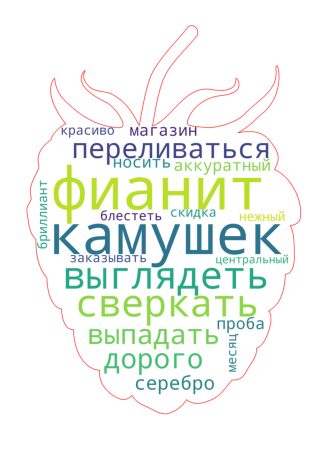

In [42]:
new_wordcloud(idf2.head(20).index)

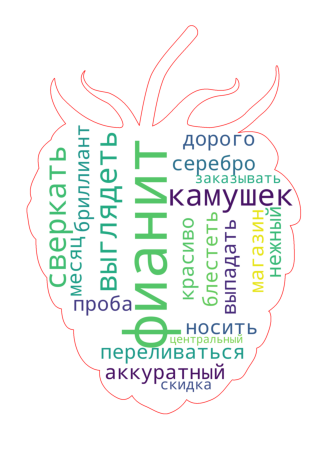

In [43]:
mask = np.array(Image.open('../berry.jpg'))
def new_wordcloud(tf_idf_indexes):
    unique_string=(" ").join(tf_idf_indexes)
    wordcloud = WordCloud(background_color='white', 
                          mask=mask,
                          width = mask.shape[1], 
                          height = mask.shape[0],
                          contour_width=3,
                          contour_color='red').generate(unique_string)
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

new_wordcloud(idf2.head(20).index)

# Saving preprocessed csv

In [44]:
df.to_csv('preprocessed_df.csv', index=False)